In [0]:
import tensorflow.keras as keras

In [0]:
#from keras.engine.input_layer import Input
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, MaxPool2D, Dropout, Activation, BatchNormalization, Reshape, Input, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
from keras.losses import mean_squared_error

from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint , LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
class CustomCallback(Callback):

  def LR_scheduler(self):
    return ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, verbose=1)
  
  def step_decay_schedule(initial_lr, decay_factor, step_size):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
  '''
  Wrapper function to create a LearningRateScheduler with step decay schedule.
  '''
  def schedule(epoch):
      new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
      
      return new_lr

  return LearningRateScheduler(schedule, verbose=1) 

In [0]:
class Variational_AutoEncoder:

  def __init__(self, input_dim, n_conv_layers, conv_layers_filters, conv_layers_kernels, conv_layers_strides, conv_transpose_layers_filters, conv_transpose_layers_kernels, conv_transpose_layers_strides, z_dim, learning_rate, r_loss_factor, x, y, epochs):
    self.input_dim = input_dim
    self.n_conv_layers = n_conv_layers
    self.conv_layers_filters = conv_layers_filters
    self.conv_layers_kernels = conv_layers_kernels
    self.conv_layers_strides = conv_layers_strides
    self.conv_transpose_layers_filters = conv_transpose_layers_filters
    self.conv_transpose_layers_kernels = conv_transpose_layers_kernels
    self.conv_transpose_layers_strides = conv_transpose_layers_strides
    self.z_dim = z_dim
    self.learning_rate = learning_rate
    self.r_loss_factor = r_loss_factor
    self.x = x
    self.y = y
    self.epochs = epochs

  def Encoder(self):

    self.encoder_input = Input(shape=(self.input_dim), name='Encoder_Input')
    x = self.encoder_input

    for i in range(self.n_conv_layers):

      conv_layer = Conv2D(filters= self.conv_layers_filters[i],
                          kernel_size= self.conv_layers_kernels[i],
                          strides= self.conv_layers_strides[i],
                          padding='same',
                          name = 'Conv_Layer_'+str(i))
      
      x = conv_layer(x)
      x = Dropout(0.25)(x)
      x = LeakyReLU()(x)
      x = BatchNormalization()(x)
    # int_shape in used because using Keras.shape() will output a Tensor but int_shape outputs a tuple
    
    self.shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)

    self.mu = Dense(self.z_dim, name='mu')(x)
    self.log_var = Dense(self.z_dim, name='log_var')(x)

    #self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

    def sampling(args):
      mu, log_var = args

      epsilon = K.random_normal(K.shape(mu), mean=0.0, stddev=1.0)
      return mu + K.exp(log_var/2)*epsilon

    self.encoder_output = Lambda(sampling, name='encoder_output') ([self.mu, self.log_var])
    self.encoder = Model(self.encoder_input, self.encoder_output)
  
  def Decoder(self,flag=0):
    #if flag==1:
    self.decoder_input = Input(shape=(self.z_dim,), name='Decoder_Input')
    x = Dense(np.prod(self.shape_before_flattening))(self.decoder_input)
    x = Reshape(self.shape_before_flattening)(x)

    #else:
    #  x = Dense(np.prod(self.shape_before_flattening))(self.encoder_output)
    #  x = Reshape(self.shape_before_flattening)(x)
                                                         
    for i in range(self.n_conv_layers):

      conv_transpose_layers = Conv2DTranspose(filters = self.conv_transpose_layers_filters[i],
                                              kernel_size = self.conv_transpose_layers_kernels[i],
                                              strides = self.conv_transpose_layers_strides[i],
                                              padding='same',
                                              name = 'conv_transpose_layer_'+str(i))
      
      x = conv_transpose_layers(x)
      x = Dropout(0.25)(x)
      

      if i<self.n_conv_layers-1:
        x = LeakyReLU()(x)
      else:
        x = Activation(activation='sigmoid')(x)
      x = BatchNormalization()(x)

    self.decoder_output = x
    self.decoder = Model(self.decoder_input, self.decoder_output)


  def Model_combine(self):
    
    #model_input = self.Encoder()
    #model_output = self.Decoder()
    self.Encoder()
    self.Decoder()
    model_input = self.encoder_input
    model_output = self.decoder(self.encoder_output)
    #self.model = Model(self.encoder_input, self.decoder_output)

    self.model = Model(model_input, model_output)

    return self.model

  #def r_loss(y_true, y_pred):
  #  return K.mean(K.square(y_true,y_pred), axis=[1,2,3])

  def get_model(self):

    self.model = self.Model_combine()

    optimizer = Adam(lr=self.learning_rate)

    def vae_r_loss(y_true,y_pred):
      r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
      return self.r_loss_factor * r_loss

    def vae_kl_loss(y_true, y_pred):

      kl_loss = -0.5* K.sum(1+ self.log_var -K.pow(self.mu,2) - K.exp(self.log_var), axis=1)
      return kl_loss

    def vae_loss(y_true, y_pred):
      r_loss = vae_r_loss(y_true, y_pred)
      kl_loss = vae_kl_loss(y_true, y_pred)
      return r_loss + kl_loss

    self.model.compile(optimizer = optimizer, loss = vae_loss, metrics=[vae_r_loss, vae_kl_loss])
    print(self.model.summary())

    

  def train(self):

       

    initial_lr = self.learning_rate
    lr_scheduler = step_decay_schedule(initial_lr, 0.1, 5)

    self.model.fit(self.x, self.y, batch_size=500, shuffle=True, epochs=self.epochs, callbacks=[lr_scheduler])
    return self.model, self.encoder, self.decoder

  def Encoder_model(self):
    #self.Encoder()
    #self.encoder = Model(self.encoder_input, self.encoder_output)
    #optimizer = Adam(lr=self.learning_rate)
    
    #self.encoder.compile(optimizer = optimizer, loss = 'mean_squared_error')
    print(self.encoder.summary())

    return self.encoder

  def Decoder_model(self):
    #self.Encoder()
    #self.Decoder(flag=1)
    #self.decoder = Model(self.decoder_input, self.decoder_output)
    #optimizer = Adam(lr=self.learning_rate)
    
    #self.decoder.compile(optimizer = optimizer, loss = 'mean_squared_error')
    print(self.decoder.summary())
    return self.decoder

   


In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

(x_train, y_train), (x_test, y_test) = (mnist.train.images, mnist.train.labels), (mnist.test.images, mnist.test.labels)
train_images = x_train.reshape(60000,28,28,1)
test_images = x_test.reshape(10000,28,28,1)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
VAE = Variational_AutoEncoder(input_dim = (28,28,1)
    , n_conv_layers = 4  
    , conv_layers_filters = [32,64,64, 64]
    , conv_layers_kernels = [3,3,3,3]
    , conv_layers_strides = [1,2,2,1]
    , conv_transpose_layers_filters = [64,64,32,1]
    , conv_transpose_layers_kernels = [3,3,3,3]
    , conv_transpose_layers_strides = [1,2,2,1]
    , z_dim = 2
    , learning_rate = 0.005
    , r_loss_factor = 1000
    , x = train_images
    , y = train_images
    , epochs = 30
)

model = VAE.get_model()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Conv_Layer_0 (Conv2D)           (None, 28, 28, 32)   320         Encoder_Input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 28, 28, 32)   0           Conv_Layer_0[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 32)   0         

In [0]:
model, encoder, decoder = VAE.train()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
60000/60000 [==============================] - 12s 201us/step - loss: 440.9876 - vae_r_loss: 432.2273 - vae_kl_loss: 8.7603
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
60000/60000 [==============================] - 6s 105us/step - loss: 112.9985 - vae_r_loss: 109.2038 - vae_kl_loss: 3.7947
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.005.
60000/60000 [==============================] - 6s 104us/step - loss: 70.8371 - vae_r_loss: 67.7578 - vae_kl_loss: 3.0793
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.005.
60000/60000 [==============================] - 6s 104us/step - loss: 68.1521 - vae_r_loss: 65.2561 - vae_kl_loss: 2.8960
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 0.005.
60000/60000 [=======

In [0]:
#model.fit(x=train_images, y=train_images, batch_size=500, shuffle=True, epochs=20)

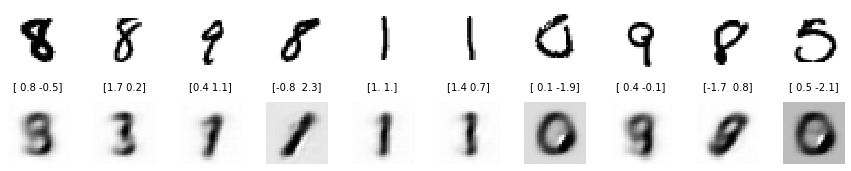

In [0]:
n_to_show = 10
example_idx = np.random.choice(range(len(test_images)), n_to_show)
example_images = test_images[example_idx]

z_points = encoder.predict(example_images)
reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

In [0]:
input_dim = (28,28,1)
n_conv_layers = 4  
conv_layers_filters = [32,64,64, 64]
conv_layers_kernels = [3,3,3,3]
conv_layers_strides = [1,2,2,1]
conv_transpose_layers_filters = [64,64,32,1]
conv_transpose_layers_kernels = [3,3,3,3]
conv_transpose_layers_strides = [1,2,2,1]
z_dim = 2
encoder = 0
decoder = 0
model = 0
learning_rate = 0.005
r_loss_factor = 1000
img_x = train_images
img_y = train_images
epochs = 5

encoder_input = Input(shape=(input_dim), name='Encoder_Input')
x = encoder_input

for i in range(n_conv_layers):

  conv_layer = Conv2D(filters= conv_layers_filters[i],
                      kernel_size= conv_layers_kernels[i],
                      strides= conv_layers_strides[i],
                      padding='same',
                      name = 'Conv_Layer_'+str(i))
  
  x = conv_layer(x)
  x = Dropout(0.25)(x)
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
# int_shape in used because using Keras.shape() will output a Tensor but int_shape outputs a tuple

shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)

mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)

#self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

def sampling(args):
  mu, log_var = args

  epsilon = K.random_normal(K.shape(mu), mean=0.0, stddev=1.0)
  return mu + K.exp(log_var/2)*epsilon

encoder_output = Lambda(sampling, name='encoder_output') ([mu, log_var])
encoder = Model(encoder_input, encoder_output)



In [0]:
decoder_input = Input(shape=(z_dim,), name='Decoder_Input')

y = Dense(np.prod(shape_before_flattening))(decoder_input)
y = Reshape(shape_before_flattening)(y)

for i in range(n_conv_layers):

  conv_transpose_layers = Conv2DTranspose(filters = conv_transpose_layers_filters[i],
                                          kernel_size = conv_transpose_layers_kernels[i],
                                          strides = conv_transpose_layers_strides[i],
                                          padding='same',
                                          name = 'conv_transpose_layer_'+str(i))
  
  y = conv_transpose_layers(y)

  if i<n_conv_layers-1:
    y = LeakyReLU()(y)
  else:
    y = Activation(activation='sigmoid')(y)

decoder_output = y
decoder = Model(decoder_input, decoder_output)
#decoder.compile(optimizer='Adam', loss='mean_squared_error')
#print(decoder.summary())

In [0]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

In [0]:
def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return  r_loss + kl_loss

optimizer = Adam(lr=learning_rate)

model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])
print(model.summary())

Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Conv_Layer_0 (Conv2D)           (None, 28, 28, 32)   320         Encoder_Input[0][0]              
__________________________________________________________________________________________________
dropout_217 (Dropout)           (None, 28, 28, 32)   0           Conv_Layer_0[0][0]               
__________________________________________________________________________________________________
leaky_re_lu_202 (LeakyReLU)     (None, 28, 28, 32)   0           dropout_217[0][0]                
___________________________________________________________________________________________

In [0]:
model.fit(img_x, img_y, batch_size=500, shuffle=True, epochs=epochs)

Epoch 1/5
60000/60000 [==============================] - 31s 516us/step - loss: 70.7351 - vae_r_loss: 66.5253 - vae_kl_loss: 4.2098
Epoch 2/5
60000/60000 [==============================] - 17s 283us/step - loss: 56.1323 - vae_r_loss: 52.4677 - vae_kl_loss: 3.6646
Epoch 3/5
60000/60000 [==============================] - 17s 283us/step - loss: 54.4114 - vae_r_loss: 50.5818 - vae_kl_loss: 3.8296
Epoch 4/5
60000/60000 [==============================] - 17s 282us/step - loss: 53.2697 - vae_r_loss: 49.3854 - vae_kl_loss: 3.8842
Epoch 5/5
60000/60000 [==============================] - 17s 283us/step - loss: 52.4571 - vae_r_loss: 48.5291 - vae_kl_loss: 3.9281


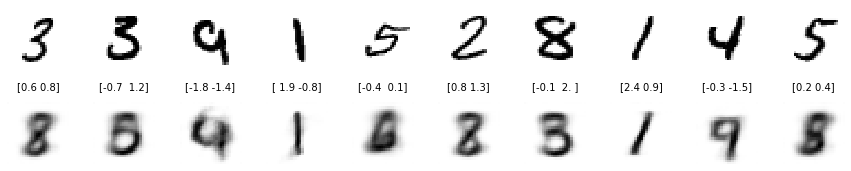

In [0]:
n_to_show = 10
example_idx = np.random.choice(range(len(test_images)), n_to_show)
example_images = test_images[example_idx]

z_points = encoder.predict(example_images)
reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

In [0]:

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

import numpy as np
import json
import os
import pickle


class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)
        
        

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        lr_sched = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=2, verbose=1)
        
        callbacks_list = [lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )

In [0]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

In [0]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
